# Análise de Inadimplência e Modelagem Preditiva

Este notebook apresenta o pipeline completo para análise, engenharia de atributos e modelagem preditiva de inadimplência, utilizando dados cadastrais, histórico de empréstimos e históricos de parcelas.

O objetivo é construir modelos robustos para prever o risco de inadimplência, com foco na métrica OVER60MOB06 uma vez que:
- FPD (First Payment Default):
    - Definição: mede se o cliente atrasa logo na primeira parcela.
    - Prós: fácil de calcular, rápida percepção do risco logo após a contratação.
    - Contras: muito sensível a problemas operacionais (erros de cobrança, débito não compensado, problemas de comunicação com o cliente). Não necessariamente indica inadimplência estrutural.

- EVER30MOB03:
  - Definição: mede se o cliente teve qualquer atraso ≥30 dias nos primeiros 3 meses do contrato.
  - Prós: Já filtra atrasos leves (evita ruído de FPD).
    Olha para os primeiros 3 meses, dando mais tempo para captar mau pagador.
  - Contras: Muito curto para crédito de médio/longo prazo. Atrasos de 30 dias podem incluir eventos pontuais (perda temporária de renda, esquecimento, problemas bancários).

- OVER60MOB06
    - Definição: mede se o cliente acumula atraso >60 dias nos primeiros 6 meses de contrato.
    - Prós: Atrasos de 60 dias ou mais são fortemente indicativos de inadimplência real (dificilmente são apenas descuidos). O período de 6 meses captura melhor os clientes que começam a atrasar depois do início do contrato.
    Menos ruído operacional, pois um cliente com 60 dias em atraso dificilmente está apenas com falhas no pagamento automático.
    - Contras: Leva mais tempo para avaliar o desempenho do crédito (não serve para produtos de curtíssimo prazo).


  De acordo com Basiléia e Normativos do BCB (Res. CMN 4.966/21, Res. BCB 352/23) Default é a partir de 90 dias de atraso (OVER60MOB06 possui uma boa correlação com perdas reais, reduz ruído. Porém é menos sensível a inadimplências muito precoces e Fraudes)

## 1. Preparação do Ambiente

Rode o script em uma máquina T4 no google colab para que o cuml e o cudf sejam utilizados (São libs que utilizam a GPU para otimizar o processo de Machine Learning e Manipulações utilizando o Pandas)

In [ ]:
# Ativando RAPIDS
%load_ext cuml.accel  #Utilizar somente no Colab com ambiente T4

cuML: Accelerator installed.


In [ ]:
%load_ext cudf.pandas #Utilizar somente no Colab com ambiente T4

## Libraries

In [ ]:
# Numéricas e manipulação de dados
import numpy as np
import pandas as pd

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento
from sklearn.preprocessing import OrdinalEncoder

# Modelagem (scikit-learn)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Avaliação e validação (scikit-learn)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    GridSearchCV
)
from sklearn import metrics
from sklearn.metrics import roc_auc_score

# Modelagem GPU (cuML)
from cuml.model_selection import GridSearchCV as cuGridSearchCV
from cuml.ensemble import RandomForestClassifier as cuRF


In [ ]:
# Configuração de exibição do pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.4f}'.format

## 2. Carregamento dos Dados

In [4]:
# Leitura dos datasets
base_cadastral = pd.read_parquet('/content/base_cadastral.parquet', engine='pyarrow')
historico_emprestimos = pd.read_parquet('/content/historico_emprestimos.parquet', engine='pyarrow')
historico_parcelas = pd.read_parquet('/content/historico_parcelas.parquet', engine='pyarrow')

## 3. Engenharia de Dados - Histórico de Parcelas

In [5]:
# Visualização inicial
display(historico_parcelas.head(3))
historico_parcelas.info()

,id_contrato,id_cliente,versao_parcela,numero_parcela,data_prevista_pagamento,data_real_pagamento,valor_previsto_parcela,valor_pago_parcela
0,1594684,100193,0.0,56,2021-12-21,2021-12-21,301.86,301.86
1,1995642,134723,1.0,38,2021-08-09,2021-08-04,12949.20,12949.20
2,1720935,176364,1.0,9,2024-03-06,2024-03-04,61192.53,61192.53


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1390978 entries, 0 to 1390977
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id_contrato              1390978 non-null  int64  
 1   id_cliente               1390978 non-null  int64  
 2   versao_parcela           1390978 non-null  float64
 3   numero_parcela           1390978 non-null  int64  
 4   data_prevista_pagamento  1390978 non-null  object 
 5   data_real_pagamento      1390639 non-null  object 
 6   valor_previsto_parcela   1390978 non-null  float64
 7   valor_pago_parcela       1390639 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 84.9+ MB


In [6]:
# Conversão de datas
historico_parcelas['data_prevista_pagamento'] = pd.to_datetime(historico_parcelas['data_prevista_pagamento'], errors="coerce")
historico_parcelas['data_real_pagamento'] = pd.to_datetime(historico_parcelas['data_real_pagamento'], errors="coerce")

# Cálculo de dias de atraso (apenas valores positivos)
historico_parcelas['dias_atraso'] = (historico_parcelas['data_real_pagamento'] - historico_parcelas['data_prevista_pagamento']).dt.days.fillna(0)
historico_parcelas['dias_atraso'] = historico_parcelas['dias_atraso'].apply(lambda x: max(x, 0))

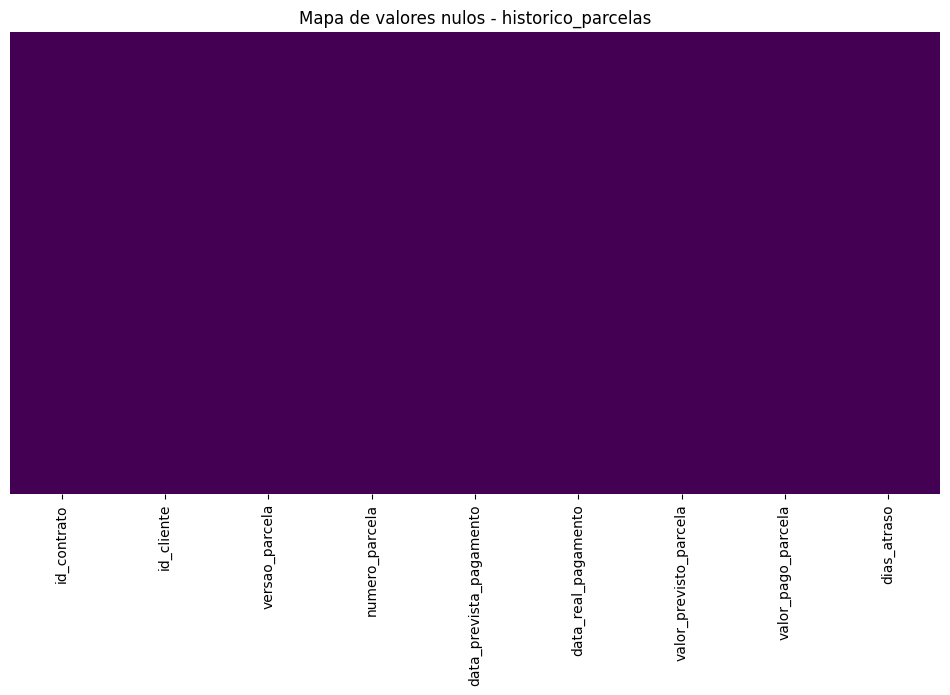

In [7]:
# Visualização de valores nulos
plt.figure(figsize=(12,6))
sns.heatmap(historico_parcelas.isna(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Mapa de valores nulos - historico_parcelas")
plt.show()

### Métricas de Default

As principais métricas de inadimplência utilizadas estão resumidas na tabela abaixo:

| Métrica           | Critério | Como calcular |
|-------------------|----------|--------------|
| FPD (First Payment Default) | Atraso na 1ª parcela | `numero_parcela==1` e `dias_atraso > 0` |
| EVER30MOB03       | Alguma parcela >30 dias de atraso nos 3 primeiros meses | `numero_parcela<=3` e `dias_atraso>30` |
| OVER60MOB06       | Soma dos atrasos >60 dias nas 6 primeiras parcelas | Soma `dias_atraso` nas 6 primeiras parcelas > 60 |

A métrica **OVER60MOB06** será utilizada como target principal, pois captura inadimplência relevante e persistente, evitando tanto falsos positivos (FPD pode ser ruído) quanto falsos negativos (EVER30MOB03 pode ser branda).

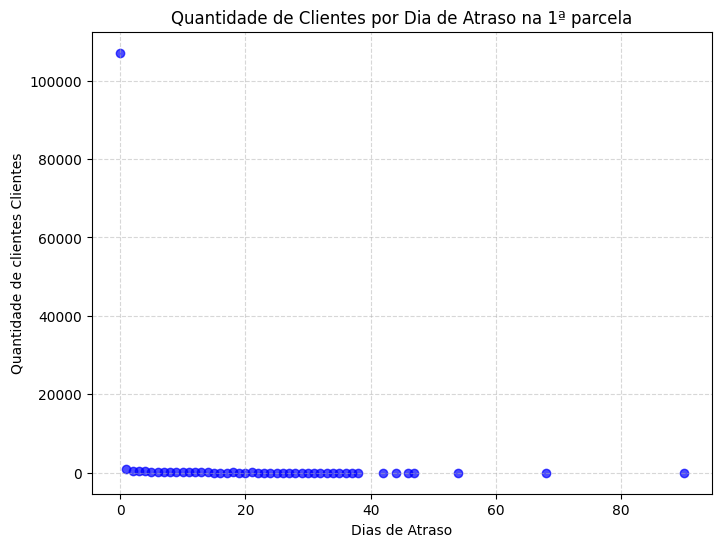

In [8]:
# Distribuição de clientes por dias de atraso na 1ª parcela
df1 = (
    historico_parcelas[historico_parcelas['numero_parcela'] == 1]
    .groupby('dias_atraso')['id_cliente'].count().reset_index()
    .sort_values('dias_atraso')
)
df1=df1[df1['id_cliente']>0]
plt.figure(figsize=(8,6))
plt.scatter(df1["dias_atraso"], df1["id_cliente"], color="blue", alpha=0.7)
plt.title("Quantidade de Clientes por Dia de Atraso na 1ª parcela")
plt.xlabel("Dias de Atraso")
plt.ylabel("Quantidade de clientes Clientes")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [9]:
df1.head(10)

,dias_atraso,id_cliente
0,0.0,107129
1,1.0,1036
2,2.0,546
3,3.0,416
4,4.0,391
5,5.0,306
6,6.0,240
7,7.0,192
8,8.0,153
9,9.0,138


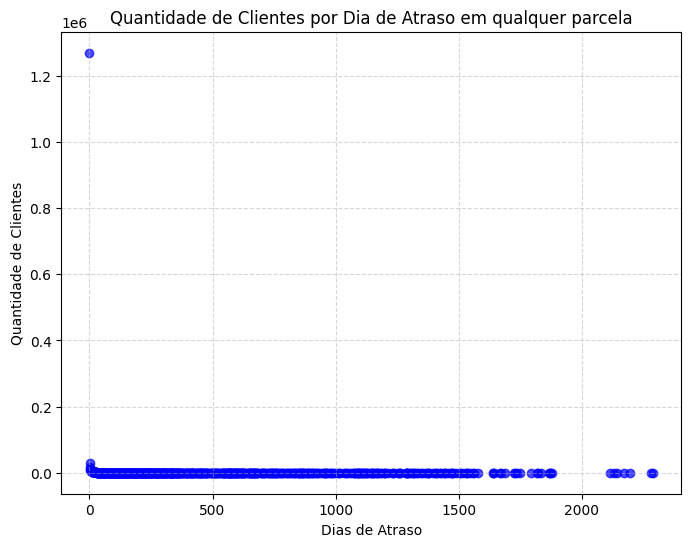

In [10]:
# Distribuição de clientes por dias de atraso em qualquer parcela
df2 = (
    historico_parcelas.groupby('dias_atraso')['id_cliente'].count().reset_index()
    .sort_values('dias_atraso')
)
df2=df2[df2['id_cliente']>0]
plt.figure(figsize=(8,6))
plt.scatter(df2["dias_atraso"], df2["id_cliente"], color="blue", alpha=0.7)
plt.title("Quantidade de Clientes por Dia de Atraso em qualquer parcela")
plt.xlabel("Dias de Atraso")
plt.ylabel("Quantidade de Clientes")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

del df1, df2

In [11]:
# Criação de flags de inadimplência (FPD, EVER30MOB03, OVER60MOB06)
for dias, nome in zip([1, 5, 10, 15, 30], ['FPD1', 'FPD5', 'FPD10', 'FPD15', 'FPD30']):
    historico_parcelas[nome] = np.where(
        (historico_parcelas['numero_parcela'] == 1) & (historico_parcelas['dias_atraso'] >= dias), 1, 0
    )

# EVER30MOB03: atraso >30 dias nas 3 primeiras parcelas
historico_parcelas['EVER30MOB03'] = (
    historico_parcelas
    .assign(flag=(historico_parcelas['numero_parcela'] <= 3) & (historico_parcelas['dias_atraso'] > 30))
    .groupby('id_contrato')['flag']
    .transform('max')
).astype(int)

# OVER60MOB06: atraso acumulado >60 dias nas 6 primeiras parcelas
historico_parcelas['acum_6m'] = (
    historico_parcelas
    .loc[historico_parcelas['numero_parcela'] <= 6]
    .groupby('id_contrato')['dias_atraso']
    .transform('sum')
)
historico_parcelas['OVER60MOB06'] = np.where(historico_parcelas['acum_6m'] > 60, 1, 0)
historico_parcelas.drop(columns=['acum_6m'], inplace=True)

In [12]:
# Análise das métricas de inadimplência
for col in ['FPD1', 'FPD5', 'FPD10', 'FPD15', 'FPD30', 'EVER30MOB03', 'OVER60MOB06']:
    print(f"{col}:\n", historico_parcelas[col].value_counts(normalize=True) * 100)

FPD1:
 FPD1
0    99.671095
1     0.328905
Name: proportion, dtype: float64
FPD5:
 FPD5
0    99.842844
1     0.157156
Name: proportion, dtype: float64
FPD10:
 FPD10
0    99.916821
1     0.083179
Name: proportion, dtype: float64
FPD15:
 FPD15
0    99.949244
1     0.050756
Name: proportion, dtype: float64
FPD30:
 FPD30
0    99.994321
1     0.005679
Name: proportion, dtype: float64
EVER30MOB03:
 EVER30MOB03
0    99.666278
1     0.333722
Name: proportion, dtype: float64
OVER60MOB06:
 OVER60MOB06
0    99.167277
1     0.832723
Name: proportion, dtype: float64


In [21]:
historico_parcelas[['id_contrato', 'id_cliente', 'numero_parcela',
       'valor_previsto_parcela', 'valor_pago_parcela', 'dias_atraso', 'FPD1',
       'FPD5', 'FPD10', 'FPD15', 'FPD30', 'EVER30MOB03', 'OVER60MOB06']].describe()

,id_contrato,id_cliente,numero_parcela,valor_previsto_parcela,valor_pago_parcela,dias_atraso,FPD1,FPD5,FPD10,FPD15,FPD30,EVER30MOB03,OVER60MOB06
count,1390978.0000,1390978.0000,1390978.0000,1390978.0000,1390639.0000,1390978.0000,1390978.0000,1390978.0000,1390978.0000,1390978.0000,1390978.0000,1390978.0000,1390978.0000
mean,1908259.1247,278845.6887,14.9210,18145.8702,18353.3723,0.9832,0.0033,0.0016,0.0008,0.0005,0.0001,0.0033,0.0083
std,535193.1822,102181.6327,20.9015,52183.4360,56500.7249,17.7747,0.0573,0.0396,0.0288,0.0225,0.0075,0.0577,0.0909
min,1000003.0000,100023.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,1437671.0000,191166.0000,4.0000,4677.1650,4106.9250,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,1902062.0000,279270.0000,8.0000,9300.5775,8980.2450,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,2371329.0000,367159.0000,15.0000,17902.5750,17246.9250,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
max,2843493.0000,456248.0000,194.0000,2784334.1400,2784334.1400,2290.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [22]:
# Feature engineering: estatísticas de atraso por cliente
atraso_stats = historico_parcelas.groupby('id_cliente')['dias_atraso'].agg(['min', 'max', 'mean']).reset_index()
atraso_stats.rename(columns={'min': 'atraso_min', 'max': 'atraso_max', 'mean': 'atraso_medio'}, inplace=True)

# Consolidando métricas por contrato
parcelas_unicas = historico_parcelas.groupby(['id_contrato', 'id_cliente'], as_index=False).agg({
    'FPD1': 'first', 'FPD5': 'first', 'FPD10': 'first', 'FPD15': 'first', 'FPD30': 'first',
    'EVER30MOB03': 'first', 'OVER60MOB06': 'first'
})

# Merge das features
df = parcelas_unicas.merge(atraso_stats, on='id_cliente', how='left')

## 4. Engenharia de Dados - Histórico de Empréstimos

In [23]:
display(historico_emprestimos.head(3))

,id_contrato,id_cliente,tipo_contrato,status_contrato,data_decisao,data_liberacao,data_primeiro_vencimento,data_ultimo_vencimento_original,data_ultimo_vencimento,data_encerramento,valor_solicitado,valor_credito,valor_bem,valor_parcela,valor_entrada,percentual_entrada,qtd_parcelas_planejadas,taxa_juros_padrao,taxa_juros_promocional,tipo_pagamento,finalidade_emprestimo,tipo_cliente,faixa_rendimento,tipo_portfolio,tipo_produto,categoria_bem,combinacao_produto,setor_vendedor,canal_venda,area_venda,dia_semana_solicitacao,hora_solicitacao,flag_ultima_solicitacao_contrato,flag_ultima_solicitacao_dia,motivo_recusa,acompanhantes_cliente,flag_seguro_contratado
0,2802425,108129,Cash loans,Approved,2024-08-29,None,2024-09-28,2027-08-14,None,None,607500.0000,679671.0000,607500.0000,25188.6150,NaN,NaN,36.0000,NaN,NaN,XNA,XNA,Repeater,low_action,Cash,x-sell,XNA,Cash X-Sell: low,XNA,Contact center,-1,THURSDAY,11,Y,1,XAP,Unaccompanied,1.0000
1,2330894,258628,Cash loans,Approved,2022-10-11,None,2022-11-10,2024-09-30,2024-08-01,2024-08-04,148500.0000,174361.5000,148500.0000,12165.2100,NaN,NaN,24.0000,NaN,NaN,Cash through the bank,XNA,Repeater,high,Cash,x-sell,XNA,Cash X-Sell: high,XNA,Credit and cash offices,-1,TUESDAY,15,Y,1,XAP,Unaccompanied,1.0000
2,1182516,267782,Cash loans,Approved,2023-04-08,None,2023-05-08,2025-09-24,None,None,405000.0000,451777.5000,405000.0000,20361.6000,NaN,NaN,30.0000,NaN,NaN,Cash through the bank,XNA,Repeater,low_normal,Cash,x-sell,XNA,Cash X-Sell: low,XNA,Credit and cash offices,-1,SATURDAY,4,Y,1,XAP,None,1.0000


In [24]:
historico_emprestimos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186890 entries, 0 to 186889
Data columns (total 37 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   id_contrato                       186890 non-null  int64  
 1   id_cliente                        186890 non-null  int64  
 2   tipo_contrato                     186890 non-null  object 
 3   status_contrato                   186890 non-null  object 
 4   data_decisao                      186890 non-null  object 
 5   data_liberacao                    7100 non-null    object 
 6   data_primeiro_vencimento          107145 non-null  object 
 7   data_ultimo_vencimento_original   101143 non-null  object 
 8   data_ultimo_vencimento            87778 non-null   object 
 9   data_encerramento                 86087 non-null   object 
 10  valor_solicitado                  186890 non-null  float64
 11  valor_credito                     186890 non-null  f

In [25]:
# Conversão de datas
for col in ['data_decisao', 'data_primeiro_vencimento', 'data_ultimo_vencimento_original', 'data_ultimo_vencimento', 'data_encerramento', 'data_liberacao']:
    historico_emprestimos[col] = pd.to_datetime(historico_emprestimos[col], errors="coerce")

# One-hot encoding para tipo_contrato
historico_emprestimos = pd.get_dummies(historico_emprestimos, columns=["tipo_contrato"], prefix="tipo_contrato", drop_first=True, dtype=int)

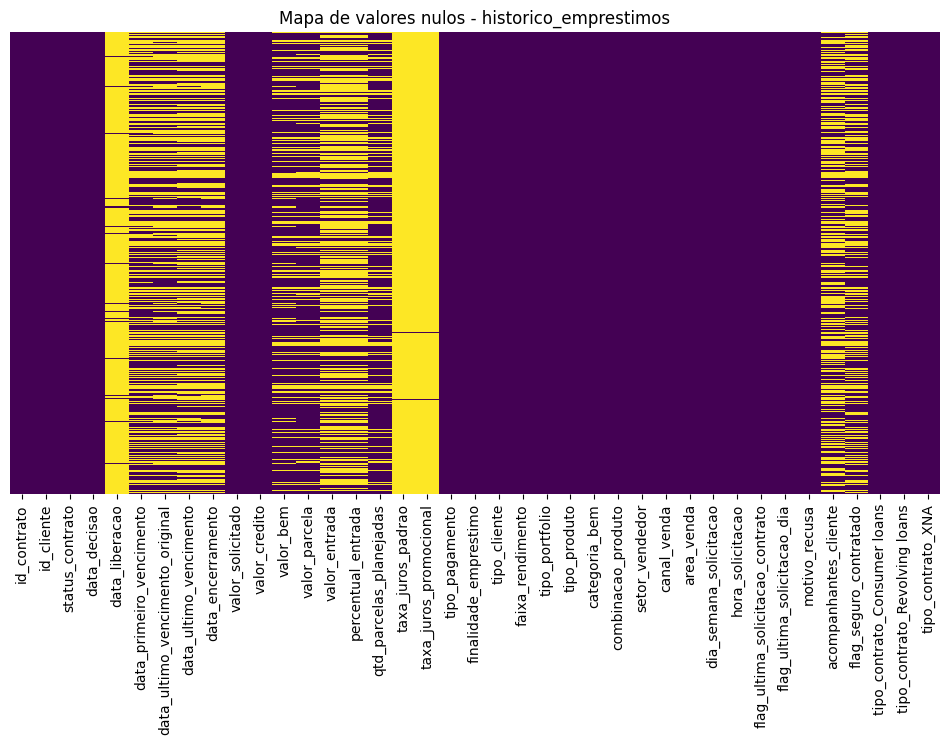

In [26]:
# Visualização de nulos
plt.figure(figsize=(12,6))
sns.heatmap(historico_emprestimos.isna(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Mapa de valores nulos - historico_emprestimos")
plt.show()

In [28]:
# Selecionar apenas colunas categóricas
cat_cols = historico_emprestimos.select_dtypes(include="object").columns

# Mostrar labels + distribuição percentual
for col in cat_cols:
    print(f"\n--- {col} ---")
    dist = (historico_emprestimos[col].value_counts(normalize=True) * 100).round(2)
    print(dist.to_string())


--- status_contrato ---
status_contrato
Approved       62.1700
Canceled       19.1400
Refused        17.1800
Unused offer    1.5200

--- tipo_pagamento ---
tipo_pagamento
Cash through the bank                       61.8400
XNA                                         37.5900
Non-cash from your account                   0.4900
Cashless from the account of the employer    0.0800

--- finalidade_emprestimo ---
finalidade_emprestimo
XAP                                55.3000
XNA                                40.5700
Repairs                             1.3900
Other                               0.8900
Urgent needs                        0.5200
Buying a used car                   0.1800
Building a house or an annex        0.1600
Everyday expenses                   0.1500
Medicine                            0.1400
Payments on other loans             0.1200
Education                           0.0900
Purchase of electronic equipment    0.0800
Wedding / gift / holiday            0.0600
Journey 

In [29]:
# Contagem de contratos por status
qtd_contratos_status = (
    historico_emprestimos.groupby(['id_cliente', 'status_contrato'])
    .size().unstack(fill_value=0).reset_index()
    .rename(columns={
        'Approved': 'qtd_contratos_approved',
        'Canceled': 'qtd_contratos_canceled',
        'Refused': 'qtd_contratos_refused',
        'Unused offer': 'qtd_contratos_unused_offer'
    })
)

In [30]:
# Flags para valores ausentes
historico_emprestimos["has_valor_bem"] = historico_emprestimos["valor_bem"].notna().astype(int)
historico_emprestimos["has_valor_parcela"] = historico_emprestimos["valor_parcela"].notna().astype(int)
historico_emprestimos["valor_bem"] = historico_emprestimos["valor_bem"].fillna(0)
historico_emprestimos["valor_parcela"] = historico_emprestimos["valor_parcela"].fillna(0)

# Merge das features de empréstimos
df1 = historico_emprestimos[['id_contrato','id_cliente','status_contrato','data_decisao','dia_semana_solicitacao',
                             'hora_solicitacao','valor_credito','valor_bem','valor_parcela','has_valor_bem','has_valor_parcela']].merge(
    qtd_contratos_status, on='id_cliente', how='left'
)
df = df.merge(df1, on=['id_cliente', 'id_contrato'], how='left')

# Flags de final de semana e horário comercial
df['weekend'] = np.where(df['dia_semana_solicitacao'].isin(['SATURDAY','SUNDAY']), 1, 0)
df['business_hour'] = np.where((df['hora_solicitacao'] >= 8) & (df['hora_solicitacao'] < 17), 1, 0)

# Variáveis de histórico do cliente
df = df.sort_values(['id_cliente', 'data_decisao','hora_solicitacao'], ascending=[True, True, True]) #Ordenando por id cliente, data decisão e Hora de solicitaçao
df['contratos_anteriores'] = df.groupby('id_cliente').cumcount() # Faz a soma acumulada da quantidade de contratos anteriores que o cliente fez
df['inadimplentes_anteriores'] = df.groupby('id_cliente')['OVER60MOB06'].cumsum() #- df['OVER60MOB06'] # Calcula a quantidade de contratos inadimplentes remover comentário para incluir o contrato corrente

df['perc_inadimplencia'] = np.where(
    df['contratos_anteriores'] > 0,
    df['inadimplentes_anteriores'] / df['contratos_anteriores'] * 100,
    0
)

## 5. Engenharia de Dados - Base Cadastral

In [31]:
display(base_cadastral.head(3))

,id_cliente,sexo,data_nascimento,qtd_filhos,qtd_membros_familia,renda_anual,tipo_renda,ocupacao,tipo_organizacao,nivel_educacao,estado_civil,tipo_moradia,possui_carro,possui_imovel,nota_regiao_cliente,nota_regiao_cliente_cidade
0,100023,F,1994-01-30,1,2.0000,90000.0000,State servant,Core staff,Kindergarten,Higher education,Single / not married,House / apartment,N,Y,2,2
1,100031,F,1973-11-13,0,1.0000,112500.0000,Working,Cooking staff,Business Entity Type 3,Secondary / secondary special,Widow,House / apartment,N,Y,3,2
2,100056,M,1975-02-19,0,2.0000,360000.0000,Working,Laborers,Transport: type 2,Secondary / secondary special,Married,House / apartment,Y,Y,2,2


In [32]:
base_cadastral.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_cliente                  40000 non-null  int64  
 1   sexo                        40000 non-null  object 
 2   data_nascimento             40000 non-null  object 
 3   qtd_filhos                  40000 non-null  int64  
 4   qtd_membros_familia         40000 non-null  float64
 5   renda_anual                 40000 non-null  float64
 6   tipo_renda                  40000 non-null  object 
 7   ocupacao                    27324 non-null  object 
 8   tipo_organizacao            40000 non-null  object 
 9   nivel_educacao              40000 non-null  object 
 10  estado_civil                40000 non-null  object 
 11  tipo_moradia                40000 non-null  object 
 12  possui_carro                40000 non-null  object 
 13  possui_imovel               400

In [33]:
# Conversão de datas
base_cadastral['data_nascimento'] = pd.to_datetime(base_cadastral['data_nascimento'], errors="coerce")
base_cadastral['ocupacao'] = base_cadastral['ocupacao'].fillna('Desconhecido')

# One-hot encoding para variáveis categóricas
for col in ["sexo", "possui_carro", "possui_imovel", "tipo_moradia", "estado_civil", "ocupacao", "tipo_renda"]:
    base_cadastral = pd.get_dummies(base_cadastral, columns=[col], prefix=col, drop_first=True, dtype=int)

# Ordinal encoding para nível de educação
ordem_educacao = [
    "Lower secondary",
    "Secondary / secondary special",
    "Incomplete higher",
    "Higher education",
    "Academic degree"
]
ord_encoder = OrdinalEncoder(categories=[ordem_educacao])
base_cadastral["nivel_educacao_encoded"] = ord_encoder.fit_transform(base_cadastral[["nivel_educacao"]])

# Renda mensal e per capita
base_cadastral['renda_mensal'] = base_cadastral['renda_anual'] / 12
base_cadastral['renda_per_capita'] = base_cadastral['renda_mensal'] / base_cadastral['qtd_membros_familia']

In [34]:
# Selecionar apenas colunas categóricas
cat_cols = base_cadastral.select_dtypes(include="object").columns

# Mostrar labels + distribuição percentual
for col in cat_cols:
    print(f"\n--- {col} ---")
    dist = (base_cadastral[col].value_counts(normalize=True) * 100).round(2)
    print(dist.to_string())


--- tipo_organizacao ---
tipo_organizacao
Business Entity Type 3   22.1000
XNA                      18.4600
Self-employed            12.6400
Other                     5.6200
Medicine                  3.4700
Government                3.3000
Business Entity Type 2    3.2800
School                    2.9000
Trade: type 7             2.5600
Construction              2.1800
Kindergarten              2.1400
Business Entity Type 1    2.0000
Transport: type 4         1.7200
Trade: type 3             1.1300
Security                  1.0600
Industry: type 9          0.9800
Industry: type 3          0.9600
Housing                   0.9300
Industry: type 11         0.8500
Military                  0.8000
Bank                      0.7700
Police                    0.7500
Transport: type 2         0.7500
Postal                    0.7300
Agriculture               0.7100
Trade: type 2             0.6400
Security Ministries       0.6000
Restaurant                0.5900
Services                  0.5300


In [35]:
base_cadastral.describe()

,id_cliente,data_nascimento,qtd_filhos,qtd_membros_familia,renda_anual,nota_regiao_cliente,nota_regiao_cliente_cidade,sexo_M,possui_carro_Y,possui_imovel_Y,tipo_moradia_House / apartment,tipo_moradia_Municipal apartment,tipo_moradia_Office apartment,tipo_moradia_Rented apartment,tipo_moradia_With parents,estado_civil_Married,estado_civil_Separated,estado_civil_Single / not married,estado_civil_Widow,ocupacao_Cleaning staff,ocupacao_Cooking staff,ocupacao_Core staff,ocupacao_Desconhecido,ocupacao_Drivers,ocupacao_HR staff,ocupacao_High skill tech staff,ocupacao_IT staff,ocupacao_Laborers,ocupacao_Low-skill Laborers,ocupacao_Managers,ocupacao_Medicine staff,ocupacao_Private service staff,ocupacao_Realty agents,ocupacao_Sales staff,ocupacao_Secretaries,ocupacao_Security staff,ocupacao_Waiters/barmen staff,tipo_renda_Commercial associate,tipo_renda_Maternity leave,tipo_renda_Pensioner,tipo_renda_State servant,tipo_renda_Student,tipo_renda_Unemployed,tipo_renda_Working,nivel_educacao_encoded,renda_mensal,renda_per_capita
count,40000.0000,40000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000,40000.0000
mean,278414.6598,1981-03-09 22:24:23.039999936,0.4132,2.1532,172853.8650,2.0515,2.0294,0.3432,0.3406,0.6922,0.8918,0.0350,0.0079,0.0154,0.0468,0.6431,0.0638,0.1456,0.0507,0.0146,0.0188,0.0875,0.3169,0.0600,0.0019,0.0383,0.0021,0.1771,0.0063,0.0691,0.0272,0.0090,0.0026,0.1047,0.0046,0.0229,0.0050,0.2313,0.0001,0.1845,0.0714,0.0001,0.0001,0.5125,1.5061,14404.4888,7878.1985
min,100023.0000,1956-02-16 00:00:00,0.0000,1.0000,26100.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2175.0000,487.5000
25%,190486.2500,1971-02-12 00:00:00,0.0000,2.0000,112500.0000,2.0000,2.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,9375.0000,4125.0000
50%,277796.5000,1981-12-31 00:00:00,0.0000,2.0000,148500.0000,2.0000,2.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,12375.0000,6250.0000
75%,367312.2500,1991-02-21 00:00:00,1.0000,3.0000,202500.0000,2.0000,2.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,2.0000,16875.0000,9375.0000
max,456248.0000,2004-03-10 00:00:00,14.0000,15.0000,117000000.0000,3.0000,3.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,4.0000,9750000.0000,3250000.0000
std,102575.2010,NaN,0.7180,0.9036,602510.2301,0.5093,0.5032,0.4748,0.4739,0.4616,0.3107,0.1837,0.0884,0.1231,0.2112,0.4791,0.2444,0.3527,0.2193,0.1200,0.1359,0.2826,0.4653,0.2374,0.0430,0.1919,0.0460,0.3817,0.0790,0.2536,0.1625,0.0944,0.0509,0.3062,0.0673

In [36]:
# Merge com o dataframe principal
df = base_cadastral.merge(df, on='id_cliente', how='left')

In [37]:
# Criação da variável idade
df["idade"] = (df["data_decisao"] - df["data_nascimento"]).dt.days // 365

## 6. Análise Exploratória e Limpeza Final

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109680 entries, 0 to 109679
Data columns (total 79 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   id_cliente                         109680 non-null  int64         
 1   data_nascimento                    109680 non-null  datetime64[ns]
 2   qtd_filhos                         109680 non-null  int64         
 3   qtd_membros_familia                109680 non-null  float64       
 4   renda_anual                        109680 non-null  float64       
 5   tipo_organizacao                   109680 non-null  object        
 6   nivel_educacao                     109680 non-null  object        
 7   nota_regiao_cliente                109680 non-null  int64         
 8   nota_regiao_cliente_cidade         109680 non-null  int64         
 9   sexo_M                             109680 non-null  int64         
 10  possui_carro_Y      

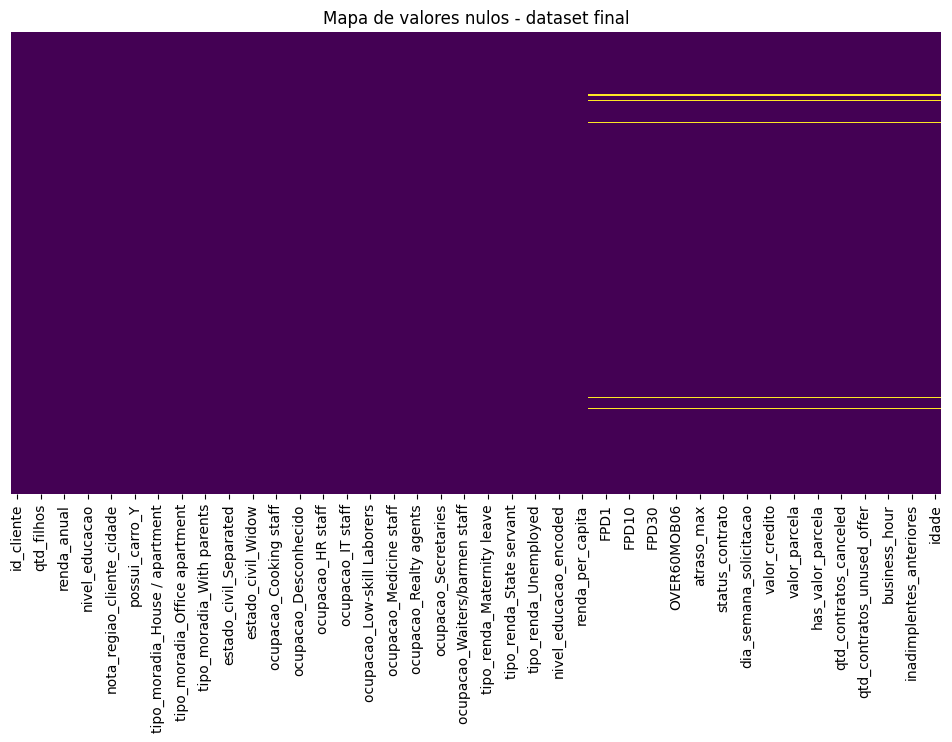

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Mapa de valores nulos - dataset final")
plt.show()

In [40]:
df[df['id_contrato'].isnull()].shape

(2261, 79)

2.261 Clientes não possuem histórico de serviços. Serão removidos da amostra
Não haverá prejuízo, pois não há classificação ou histórico de inadimplencia para esses clientes.

In [41]:
# Remoção de registros inválidos
df = df[df['id_contrato'].notnull()]

In [42]:
# Quantidade e percentual de nulos
df.isnull().sum()

,0
id_cliente,0
data_nascimento,0
qtd_filhos,0
qtd_membros_familia,0
renda_anual,0
tipo_organizacao,0
nivel_educacao,0
nota_regiao_cliente,0
nota_regiao_cliente_cidade,0
sexo_M,0


In [43]:
# Distribuição da variável target
contagem = df['OVER60MOB06'].value_counts()
percentual = df['OVER60MOB06'].value_counts(normalize=True) * 100
df_fpd1 = pd.DataFrame({'qtd': contagem, 'percentual': percentual.round(2)}).reset_index().rename(columns={'index':'OVER60MOB06'})
print(df_fpd1)

   OVER60MOB06     qtd  percentual
0       0.0000  106595     99.2300
1       1.0000     824      0.7700


In [44]:
df.describe()

,id_cliente,data_nascimento,qtd_filhos,qtd_membros_familia,renda_anual,nota_regiao_cliente,nota_regiao_cliente_cidade,sexo_M,possui_carro_Y,possui_imovel_Y,tipo_moradia_House / apartment,tipo_moradia_Municipal apartment,tipo_moradia_Office apartment,tipo_moradia_Rented apartment,tipo_moradia_With parents,estado_civil_Married,estado_civil_Separated,estado_civil_Single / not married,estado_civil_Widow,ocupacao_Cleaning staff,ocupacao_Cooking staff,ocupacao_Core staff,ocupacao_Desconhecido,ocupacao_Drivers,ocupacao_HR staff,ocupacao_High skill tech staff,ocupacao_IT staff,ocupacao_Laborers,ocupacao_Low-skill Laborers,ocupacao_Managers,ocupacao_Medicine staff,ocupacao_Private service staff,ocupacao_Realty agents,ocupacao_Sales staff,ocupacao_Secretaries,ocupacao_Security staff,ocupacao_Waiters/barmen staff,tipo_renda_Commercial associate,tipo_renda_Maternity leave,tipo_renda_Pensioner,tipo_renda_State servant,tipo_renda_Student,tipo_renda_Unemployed,tipo_renda_Working,nivel_educacao_encoded,renda_mensal,renda_per_capita,id_contrato,FPD1,FPD5,FPD10,FPD15,FPD30,EVER30MOB03,OVER60MOB06,atraso_min,atraso_max,atraso_medio,data_decisao,hora_solicitacao,valor_credito,valor_bem,valor_parcela,has_valor_bem,has_valor_parcela,qtd_contratos_approved,qtd_contratos_canceled,qtd_contratos_refused,qtd_contratos_unused_offer,weekend,business_hour,contratos_anteriores,inadimplentes_anteriores,perc_inadimplencia,idade
count,107419.0000,107419,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000,107419.0000
mean,278505.6963,1980-07-09 14:51:22.113964928,0.4159,2.1664,173127.6850,2.0604,2.0356,0.3273,0.3409,0.7151,0.8985,0.0351,0.0072,0.0139,0.0427,0.6536,0.0644,0.1290,0.0562,0.0163,0.0202,0.0828,0.3273,0.0572,0.0016,0.0367,0.0017,0.1788,0.0062,0.0639,0.0286,0.0090,0.0024,0.1057,0.0042,0.0230,0.0044,0.2237,0.0000,0.1963,0.0684,0.0000,0.0001,0.5114,1.4535,14427.3071,7854.1084,1906249.8159,0.0043,0.0020,0.0011,0.0006,0.0001,0.0023,0.0077,0.0001,18.7482,0.8776,2021-12-31 12:12:17.165678336,12.6116,193752.9704,175246.6307,14543.6999,0.9658,1.0000,4.4944,1.2561,1.2031,0.0964,0.2742,0.8074,1.5977,0.0258,1.0817,41.0070
min,100023.0000,1956-02-16 00:00:00,0.0000,1.0000,26100.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2175.0000,487.5000,1000003.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2017-02-04 00:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,18.0000
25%,190506.0000,1970-06-14 00:00:00,0.0000,2.0000,112500.0000,2.0000,2.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,9375.0000,4218.7500,1436985.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2020-06-04 12:00:00,10.0000,47911.5000,45000.000

Há um desbalanceamento Severo. Para cada cliente classificado como inadimplente é preciso cerca de 128 clientes classificados como adimplente.

Por tanto é preciso calibrar os modelos para que penalize classificações erradas na classe 1 (Inadimplente)

## 7. Modelagem Preditiva

### 7.1. Preparação dos Dados para Modelagem

In [ ]:
# Seleção de features (removendo identificadores e variáveis não preditivas)
X = df.drop(columns=[
    'id_contrato','id_cliente','status_contrato','dia_semana_solicitacao','tipo_organizacao',
    'FPD1','FPD5','FPD10','FPD15','FPD30','EVER30MOB03','OVER60MOB06',
    'nivel_educacao','data_nascimento','data_decisao','hora_solicitacao','renda_anual'
])
y = df['OVER60MOB06']

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [48]:
X.columns

Index(['qtd_filhos', 'qtd_membros_familia', 'nota_regiao_cliente',
       'nota_regiao_cliente_cidade', 'sexo_M', 'possui_carro_Y',
       'possui_imovel_Y', 'tipo_moradia_House / apartment',
       'tipo_moradia_Municipal apartment', 'tipo_moradia_Office apartment',
       'tipo_moradia_Rented apartment', 'tipo_moradia_With parents',
       'estado_civil_Married', 'estado_civil_Separated',
       'estado_civil_Single / not married', 'estado_civil_Widow',
       'ocupacao_Cleaning staff', 'ocupacao_Cooking staff',
       'ocupacao_Core staff', 'ocupacao_Desconhecido', 'ocupacao_Drivers',
       'ocupacao_HR staff', 'ocupacao_High skill tech staff',
       'ocupacao_IT staff', 'ocupacao_Laborers', 'ocupacao_Low-skill Laborers',
       'ocupacao_Managers', 'ocupacao_Medicine staff',
       'ocupacao_Private service staff', 'ocupacao_Realty agents',
       'ocupacao_Sales staff', 'ocupacao_Secretaries',
       'ocupacao_Security staff', 'ocupacao_Waiters/barmen staff',
       'tipo_renda_

### 7.2. Regressão Logística (Logit)

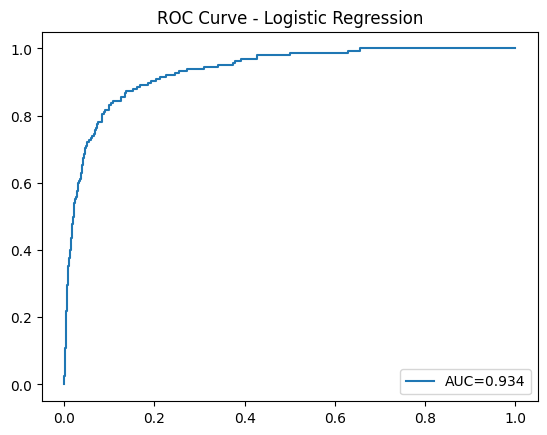

[[20436   883]
 [   56   109]]
              precision    recall  f1-score   support

  adimplente       1.00      0.96      0.98     21319
inadimplente       0.11      0.66      0.19       165

    accuracy                           0.96     21484
   macro avg       0.55      0.81      0.58     21484
weighted avg       0.99      0.96      0.97     21484



In [ ]:
logit_model = LogisticRegression(
    random_state=42, max_iter=50000, solver='saga', class_weight='balanced'
)
logit_model.fit(X_train, y_train)
y_pred = logit_model.predict(X_test)

# Avaliação
y_pred_proba = logit_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.legend(loc=4)
plt.title("ROC Curve - Logistic Regression")
plt.show()

print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, target_names=['adimplente','inadimplente']))

In [ ]:
model = LogisticRegression(
    random_state=42, penalty="l2", max_iter=50000,
    solver='saga', class_weight="balanced"
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
aucs = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
auc_logit=aucs.mean()
print(f"AUC-ROC (CV=5): Média: {aucs.mean():.4f} | coef. Variação: {(aucs.std()/aucs.mean())*100:.2f}%")


AUC-ROC (CV=5): Média: 0.9262 | coef. Variação: 1.49%


### 7.3. Árvore de Decisão (Decision Tree)

In [ ]:
dt = DecisionTreeClassifier(class_weight="balanced", random_state=42)
param_grid = {
    "criterion": ["gini"],
    "max_depth": [3, 5, 7, 9],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10]
}
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
grid = GridSearchCV(dt, param_grid, scoring="roc_auc", cv=cv, verbose=2, refit=True)
grid.fit(X, y)
print("Melhor AUC médio na validação cruzada: ", grid.best_score_)
print("Melhores hiperparâmetros: ", grid.best_params_)
dt_auc=grid.best_score_
best_dt = grid.best_estimator_

Fitting 4 folds for each of 64 candidates, totalling 256 fits
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   1.3s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   1.3s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   1.3s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   1.3s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   1.3s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   1.6s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   1.7s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   1.3s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=10; total time=   1.3s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=

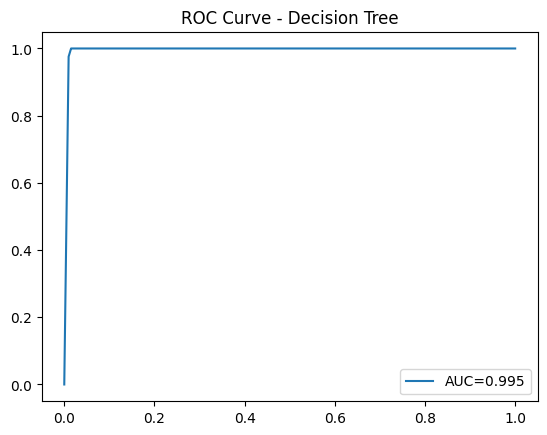

In [ ]:
# Avaliação
y_pred_proba = best_dt.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.legend(loc=4)
plt.title("ROC Curve - Decision Tree")
plt.show()

### 7.4. Random Forest (GPU e Scikit-learn)

In [ ]:
rf = cuRF(n_estimators=200, random_state=42)
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [8, 12, 16],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
grid = cuGridSearchCV(rf, param_grid, scoring="roc_auc", cv=4, verbose=2)
grid.fit(X_train, y_train)
print("Melhor AUC médio na validação cruzada: ", grid.best_score_)
print("Melhores hiperparâmetros: ", grid.best_params_)
auc_rf=grid.best_score_
best_rf = grid.best_estimator_

Fitting 4 folds for each of 81 candidates, totalling 324 fits
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.4s
[CV] END max_depth=8, min_samples_leaf

In [ ]:
# Modelo Random Forest scikit-learn (para comparação)
clf_rf = RandomForestClassifier(n_estimators=300, max_depth=8, min_samples_leaf=2, min_samples_split=5, random_state=42)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=300, random_state=42)

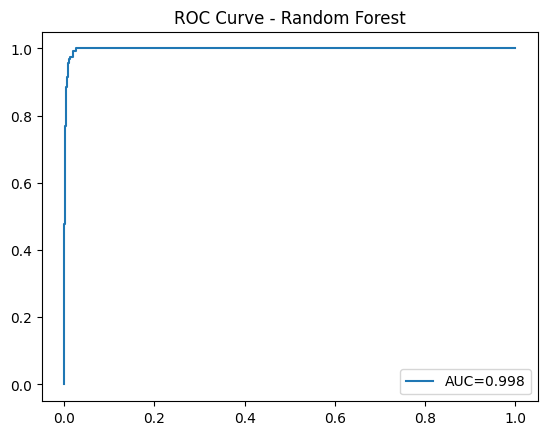

In [ ]:
y_pred_proba = clf_rf.predict_proba(X_test)[:,1]
y_pred = clf_rf.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.legend(loc=4)
plt.title("ROC Curve - Random Forest")
plt.show()

### 7.5 Identificando o melhor modelo baseado no AUC

Optou-se por escolher o AUC como métrica de escolha do modelo, pelos seguintes motivos:

    - 1º Independe de Threshold (Recall, F1, Precision, Acurácia,...);
    - 2º Mensura a capacidade do modelo separar as classes corretamente (0,5: modelo aleatório, 1: separação perfeita)
    - 3º É robusto ao desbalanceamento das classes

A ROC curve plota TPR (Sensibilidade) no eixo y vs. FPR (1 - TNR(Especificidade)) no eixo x para todos os thresholds possíveis.

In [ ]:
# Função para calcular AUC
def calcular_auc(model, X_test, y_test, threshold=0.5):
    y_proba = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_proba)
    return auc

auc_logit = calcular_auc(logit_model, X_test, y_test)
auc_dt = calcular_auc(best_dt, X_test, y_test)
auc_rf = calcular_auc(clf_rf, X_test, y_test)

df_metricas = pd.DataFrame({
    "Modelo": ["Logistic Regression", "Decision Tree", "Random Forest (GPU)"],
    "AUC": [auc_logit, auc_dt, auc_rf],
})
display(df_metricas.sort_values(by='AUC', ascending=False))

,Modelo,AUC
2,Random Forest (GPU),0.997955
1,Decision Tree,0.994986
0,Logistic Regression,0.934337


Será utilizado o Ranfom Forest pois apresentou melhor AUC, isto é, melhor capacidade de distinção entre as classes (Adimplente e Inadimplente) independentemente de threshold.

### 7.6. Identificando o Threshold que máximiza a quantidade de Inadimplentes

In [ ]:
y_pred_proba = clf_rf.predict_proba(X_test)[:,1]
y_pred = (y_pred_proba >= 0.049).astype(int)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, target_names=['adimplente','inadimplente']))

[[20752   567]
 [    0   165]]
              precision    recall  f1-score   support

  adimplente       1.00      0.97      0.99     21319
inadimplente       0.23      1.00      0.37       165

    accuracy                           0.97     21484
   macro avg       0.61      0.99      0.68     21484
weighted avg       0.99      0.97      0.98     21484



Um threshold de ~4,9% classifica todos os inadimplentes corretamente.

## 8. Predição Base de submissão

Nesta sessão é feito todo o processamento anterior, visando criar as predições para a base_submissao

In [ ]:
# Leitura dos datasets
base_cadastral = pd.read_parquet('/content/base_cadastral.parquet', engine='pyarrow')
historico_emprestimos = pd.read_parquet('/content/historico_emprestimos.parquet', engine='pyarrow')
historico_parcelas = pd.read_parquet('/content/historico_parcelas.parquet', engine='pyarrow')
base_submissao = pd.read_parquet('/content/base_submissao.parquet', engine='pyarrow')

/usr/local/lib/python3.12/dist-packages/cudf/io/parquet.py:898: UserWarning: Using CPU via PyArrow to read Parquet dataset. This option is both inefficient and unstable!
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/cudf/io/parquet.py:898: UserWarning: Using CPU via PyArrow to read Parquet dataset. This option is both inefficient and unstable!
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/cudf/io/parquet.py:898: UserWarning: Using CPU via PyArrow to read Parquet dataset. This option is both inefficient and unstable!
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/cudf/io/parquet.py:898: UserWarning: Using CPU via PyArrow to read Parquet dataset. This option is both inefficient and unstable!
  warnings.warn(


In [ ]:
# Supondo que as duas bases tenham a coluna 'id_cliente'
ids_submissao = base_submissao['id_cliente']
ids_historico = historico_emprestimos['id_cliente']

# Conjunto de IDs para acelerar busca
set_historico = set(ids_historico)

# Filtrar apenas IDs que também estão no histórico
ids_comuns = ids_submissao[ids_submissao.isin(set_historico)]

# Quantidade de IDs coincidentes
qtd_comuns = ids_comuns.nunique()

print(f"Quantidade de clientes na base_submissao que também estão no historico_emprestimos: {qtd_comuns}")
print(f'Novos solicitantes: {base_submissao['id_cliente'].nunique()-qtd_comuns}')

Quantidade de clientes na base_submissao que também estão no historico_emprestimos: 37952
Novos solicitantes: 2048


In [ ]:
def processar_base_cadastral(base_cadastral):
    """
    Processa a base cadastral conforme o pipeline do treino.
    """
    base = base_cadastral.copy()
    base['data_nascimento'] = pd.to_datetime(base['data_nascimento'], errors='coerce')
    base['ocupacao'] = base['ocupacao'].fillna('Desconhecido')
    # One-hot encoding para variáveis categóricas
    for col in ["sexo", "possui_carro", "possui_imovel", "tipo_moradia", "estado_civil", "ocupacao", "tipo_renda"]:
        base = pd.get_dummies(base, columns=[col], prefix=col, drop_first=True, dtype=int)
    # Ordinal encoding para nível de educação
    ordem_educacao = [
        "Lower secondary",
        "Secondary / secondary special",
        "Incomplete higher",
        "Higher education",
        "Academic degree"
    ]
    ord_encoder = OrdinalEncoder(categories=[ordem_educacao])
    base["nivel_educacao_encoded"] = ord_encoder.fit_transform(base[["nivel_educacao"]])
    # Renda mensal e per capita
    base['renda_mensal'] = base['renda_anual'] / 12
    base['renda_per_capita'] = base['renda_mensal'] / base['qtd_membros_familia']
    return base

def features_submissao(df):
    """
    Cria features derivadas da base_submissao.
    """
    df = df.copy()
    df['data_solicitacao'] = pd.to_datetime(df['data_solicitacao'], errors='coerce')
    df['weekend'] = df['dia_semana_solicitacao'].isin(['SATURDAY', 'SUNDAY']).astype(int)
    df['business_hour'] = ((df['hora_solicitacao'] >= 8) & (df['hora_solicitacao'] < 17)).astype(int)
    df["has_valor_bem"] = df["valor_bem"].notna().astype(int)
    df["has_valor_parcela"] = df["valor_parcela"].notna().astype(int)
    df["valor_bem"] = df["valor_bem"].fillna(0)
    df["valor_parcela"] = df["valor_parcela"].fillna(0)
    return df

def calcular_idade(df):
    """
    Calcula a idade do cliente na data da solicitação.
    """
    df['idade'] = (df['data_solicitacao'] - df['data_nascimento']).dt.days // 365
    return df

def features_historico(df, historico_emprestimos, historico_parcelas):
    """
    Gera features históricas do cliente, replicando o pipeline do treino.
    """
    # --- 1. Cálculo de flags de inadimplência nas parcelas ---
    historico_parcelas = historico_parcelas.copy()
    historico_parcelas['data_prevista_pagamento'] = pd.to_datetime(historico_parcelas['data_prevista_pagamento'], errors='coerce')
    historico_parcelas['data_real_pagamento'] = pd.to_datetime(historico_parcelas['data_real_pagamento'], errors='coerce')
    historico_parcelas['dias_atraso'] = (historico_parcelas['data_real_pagamento'] - historico_parcelas['data_prevista_pagamento']).dt.days.fillna(0)
    historico_parcelas['dias_atraso'] = historico_parcelas['dias_atraso'].apply(lambda x: max(x, 0))

    # OVER60MOB06: atraso acumulado >60 dias nas 6 primeiras parcelas
    historico_parcelas['acum_6m'] = (
        historico_parcelas
        .loc[historico_parcelas['numero_parcela'] <= 6]
        .groupby('id_contrato')['dias_atraso']
        .transform('sum')
    )
    historico_parcelas['OVER60MOB06'] = np.where(historico_parcelas['acum_6m'] > 60, 1, 0)
    historico_parcelas.drop(columns=['acum_6m'], inplace=True)

    # Consolidando OVER60MOB06 por contrato (uma linha por contrato)
    contratos_over60 = (
        historico_parcelas.groupby(['id_contrato', 'id_cliente'], as_index=False)
        .agg({'OVER60MOB06': 'first'})
    )

    # --- 2. Estatísticas de atraso por cliente ---
    atraso_stats = historico_parcelas.groupby('id_cliente')['dias_atraso'].agg(['min', 'max', 'mean']).reset_index()
    atraso_stats.rename(columns={'min': 'atraso_min', 'max': 'atraso_max', 'mean': 'atraso_medio'}, inplace=True)

    # --- 3. Contagem de contratos por status ---
    contratos_status = (
        historico_emprestimos
        .groupby(['id_cliente', 'status_contrato'])
        .size()
        .unstack(fill_value=0)
        .reset_index()
        .rename(columns={
            'Approved': 'qtd_contratos_approved',
            'Canceled': 'qtd_contratos_canceled',
            'Refused': 'qtd_contratos_refused',
            'Unused offer': 'qtd_contratos_unused_offer'
        })
    )

    # --- 4. Merge das features históricas ---
    # Merge OVER60MOB06 por contrato
    if 'id_contrato' in df.columns:
        df = df.merge(contratos_over60, on=['id_contrato', 'id_cliente'], how='left')
    else:
        # Se não houver id_contrato, agregue por cliente (último contrato, por exemplo)
        ultimos_contratos = contratos_over60.sort_values('id_contrato').drop_duplicates('id_cliente', keep='last')
        df = df.merge(ultimos_contratos[['id_cliente', 'OVER60MOB06']], on='id_cliente', how='left')

    # Merge atraso_stats
    df = df.merge(atraso_stats, on='id_cliente', how='left')
    # Merge contratos_status
    df = df.merge(contratos_status, on='id_cliente', how='left')

    # --- 5. Features de histórico de inadimplência ---
    # Aqui usamos o historico_emprestimos (ordenado por data_decisao)
    historico_enriquecido = (
        historico_emprestimos
        .merge(contratos_over60, on=['id_contrato', 'id_cliente'], how='left')
        .sort_values(['id_cliente', 'data_decisao','hora_solicitacao'],ascending=[True,True,True])
    )
    historico_enriquecido['contratos_anteriores'] = historico_enriquecido.groupby('id_cliente').cumcount() + 1 # O 1º contrato já conta na parte de predição
    historico_enriquecido['inadimplentes_anteriores'] = historico_enriquecido.groupby('id_cliente')['OVER60MOB06'].cumsum() #- historico_enriquecido['OVER60MOB06']
    historico_enriquecido['perc_inadimplencia'] = np.where(
        ((historico_enriquecido['contratos_anteriores'] == 0) & (historico_enriquecido['inadimplentes_anteriores']>0)) ,
        100,
        historico_enriquecido['inadimplentes_anteriores'] / (historico_enriquecido['contratos_anteriores']) * 100 #Soma-se 1 aqui para refletir a quantidade de contratos anteriores corrente real
    )

    # Só trazemos as colunas relevantes para merge
    historico_enriquecido = historico_enriquecido[['id_contrato', 'id_cliente','data_decisao','hora_solicitacao', 'contratos_anteriores', 'inadimplentes_anteriores', 'perc_inadimplencia']]

    # Merge no df final
    if 'id_contrato' in df.columns:
        df = df.merge(historico_enriquecido, on=['id_contrato', 'id_cliente'], how='left')
    else:
        ultimos_hist = (historico_enriquecido
                        .sort_values(['id_contrato','data_decisao','hora_solicitacao'],
                                     ascending=[True, True, True])
                        .drop_duplicates('id_cliente', keep='last'))
        df = df.merge(ultimos_hist[['id_cliente', 'contratos_anteriores', 'inadimplentes_anteriores', 'perc_inadimplencia']], on='id_cliente', how='left')
    # --- 6. Preenchimento de NaN para clientes sem histórico ---
    features_historicas = [
        'qtd_contratos_approved', 'qtd_contratos_canceled', 'qtd_contratos_refused',
        'qtd_contratos_unused_offer', 'atraso_min', 'atraso_max', 'atraso_medio',
        'contratos_anteriores', 'inadimplentes_anteriores', 'perc_inadimplencia', 'OVER60MOB06'
    ]
    for col in features_historicas:
        if col in df.columns:
            df[col] = df[col].fillna(0)

    return df

def alinhar_dummies(df, colunas_treino):
    """
    Garante que todas as colunas dummies do treino estejam presentes no dataframe de predição.
    """
    for col in colunas_treino:
        if col not in df.columns:
            df[col] = 0
    return df[colunas_treino]

In [ ]:
### Processamento base de submissão
# 1. Processa base cadastral
base_cadastral_proc = processar_base_cadastral(base_cadastral)

# 2. Junta com base_submissao
df = base_submissao.merge(base_cadastral_proc, on='id_cliente', how='left')

# 3. Features da submissão
df = features_submissao(df)

# 4. Idade
df = calcular_idade(df)

# 5. Features históricas
df = features_historico(df, historico_emprestimos, historico_parcelas)

In [ ]:
X_predict=df[['qtd_filhos', 'qtd_membros_familia', 'nota_regiao_cliente',
       'nota_regiao_cliente_cidade', 'sexo_M', 'possui_carro_Y',
       'possui_imovel_Y', 'tipo_moradia_House / apartment',
       'tipo_moradia_Municipal apartment', 'tipo_moradia_Office apartment',
       'tipo_moradia_Rented apartment', 'tipo_moradia_With parents',
       'estado_civil_Married', 'estado_civil_Separated',
       'estado_civil_Single / not married', 'estado_civil_Widow',
       'ocupacao_Cleaning staff', 'ocupacao_Cooking staff',
       'ocupacao_Core staff', 'ocupacao_Desconhecido', 'ocupacao_Drivers',
       'ocupacao_HR staff', 'ocupacao_High skill tech staff',
       'ocupacao_IT staff', 'ocupacao_Laborers', 'ocupacao_Low-skill Laborers',
       'ocupacao_Managers', 'ocupacao_Medicine staff',
       'ocupacao_Private service staff', 'ocupacao_Realty agents',
       'ocupacao_Sales staff', 'ocupacao_Secretaries',
       'ocupacao_Security staff', 'ocupacao_Waiters/barmen staff',
       'tipo_renda_Commercial associate', 'tipo_renda_Maternity leave',
       'tipo_renda_Pensioner', 'tipo_renda_State servant',
       'tipo_renda_Student', 'tipo_renda_Unemployed', 'tipo_renda_Working',
       'nivel_educacao_encoded', 'renda_mensal', 'renda_per_capita',
       'atraso_min', 'atraso_max', 'atraso_medio', 'valor_credito',
       'valor_bem', 'valor_parcela', 'has_valor_bem', 'has_valor_parcela',
       'qtd_contratos_approved', 'qtd_contratos_canceled',
       'qtd_contratos_refused', 'qtd_contratos_unused_offer', 'weekend',
       'business_hour', 'contratos_anteriores', 'inadimplentes_anteriores',
       'perc_inadimplencia', 'idade']]

In [ ]:
y_pred_proba = clf_rf.predict_proba(X_predict)[:,1]

predicao=pd.DataFrame({'id_cliente': base_submissao['id_cliente'],
              'probabilidade_inadimplencia':y_pred_proba})


In [ ]:
predicao['probabilidade_inadimplencia'].describe()

,probabilidade_inadimplencia
count,40000.000000
mean,0.002757
std,0.013303
min,0.000083
25%,0.000265
50%,0.000365
75%,0.000554
max,0.312637


In [ ]:
predicao[predicao['probabilidade_inadimplencia']==predicao['probabilidade_inadimplencia'].max()]

,id_cliente,probabilidade_inadimplencia
39300,407840,0.312637


In [ ]:
df[df['id_cliente']==407840]

,id_cliente,data_solicitacao,dia_semana_solicitacao,hora_solicitacao,tipo_contrato,valor_credito,valor_bem,valor_parcela,data_nascimento,qtd_filhos,qtd_membros_familia,renda_anual,tipo_organizacao,nivel_educacao,nota_regiao_cliente,nota_regiao_cliente_cidade,sexo_M,possui_carro_Y,possui_imovel_Y,tipo_moradia_House / apartment,tipo_moradia_Municipal apartment,tipo_renda_Working,nivel_educacao_encoded,renda_mensal,renda_per_capita,weekend,business_hour,has_valor_bem,has_valor_parcela,idade,OVER60MOB06,atraso_min,atraso_max,atraso_medio,qtd_contratos_approved,qtd_contratos_canceled,qtd_contratos_refused,qtd_contratos_unused_offer,contratos_anteriores,inadimplentes_anteriores,perc_inadimplencia
39300,407840,2025-02-24,MONDAY,13,Cash loans,305640.0,270000.0,36400.5,1971-04-06,0,1.0,180000.0,Other,Secondary / secondary special,1,1,0,1,1,1,0,0,1.0,15000.0,15000.0,0,1,1,1,53,1,0,172,24.571429,1,0,0,0,1,1,100.0


In [ ]:
predicao.to_csv('submissao_case.csv', index=False)

## 9. Política de Crédito sugerida baseada no modelo

Em vez de escolher um limite de aprovação “no chute” (ex.: aprovar todo mundo com PD < 5%), você define faixas com base na distribuição real dos clientes.

O uso de quartis (Q1, Q2, Q3) garante que as categorias sejam proporcionais ao perfil da carteira, não apenas definidas por intuição.

In [ ]:
# Probabilidades preditas pelo modelo
y_pred_proba = clf_rf.predict_proba(X_test)[:, 1]

# Threshold personalizado baseado no quartil inferior dos inadimplentes
threshold = 0.049
y_pred_class = (y_pred_proba >= threshold).astype(int)

# Filtrar apenas clientes classificados como inadimplentes
probs_inadimplentes = y_pred_proba[y_pred_class == 1]

# Calcular quartis e P90
q1, q2, q3, p90 = np.quantile(probs_inadimplentes, [0.25, 0.5, 0.75, 0.9])

# Converter para porcentagem
muito_baixo_pct = threshold * 100
q2_pct, q3_pct, p90_pct = q2*100, q3*100, p90*100

# Montar a tabela de política
politica_df = pd.DataFrame({
    "Faixa de PD (%)": [
        f"PD < {muito_baixo_pct:.2f}%",                   # Muito baixo
        f"{muito_baixo_pct:.2f}% ≤ PD < {q2_pct:.2f}%",   # Baixo
        f"{q2_pct:.2f}% ≤ PD < {q3_pct:.2f}%",            # Médio
        f"{q3_pct:.2f}% ≤ PD < {p90_pct:.2f}%",           # Alto
        f"PD ≥ {p90_pct:.2f}%"                            # Recusa imediata
    ],
    "Risco": ["Muito baixo", "Baixo", "Médio", "Alto", "Altíssimo"],
    "Política de Crédito": [
        "Aprovação automática",
        "Aprovação condicional",
        "Restrito",
        "Restrito com fortes garantias",
        "Recusa imediata"
    ],
    "Observações": [
        "Pode oferecer condições mais favoráveis (taxa menor, limite maior).",
        "Limite menor que o padrão.",
        "Analisar histórico detalhado e possíveis garantias.",
        "Apenas com garantias robustas e juros altos.",
        "Não liberar crédito em hipótese alguma."
    ]
})

# Exibir tabela final
print(politica_df.to_string(index=False))


     Faixa de PD (%)       Risco           Política de Crédito                                                         Observações
          PD < 4.90% Muito baixo          Aprovação automática Pode oferecer condições mais favoráveis (taxa menor, limite maior).
  4.90% ≤ PD < 9.69%       Baixo         Aprovação condicional                                          Limite menor que o padrão.
 9.69% ≤ PD < 20.44%       Médio                      Restrito                 Analisar histórico detalhado e possíveis garantias.
20.44% ≤ PD < 32.08%        Alto Restrito com fortes garantias                        Apenas com garantias robustas e juros altos.
         PD ≥ 32.08%   Altíssimo               Recusa imediata                             Não liberar crédito em hipótese alguma.


| Faixa de PD (%)        | Risco       | Política de Crédito           | Observações                                                        |
|------------------------|------------|--------------------------------|--------------------------------------------------------------------|
| PD < 4.90%             | Muito baixo| Aprovação automática           | Pode oferecer condições mais favoráveis (taxa menor, limite maior). |
| 4.90% ≤ PD < 9.69%     | Baixo      | Aprovação condicional          | Limite menor que o padrão.                                         |
| 9.69% ≤ PD < 20.44%    | Médio      | Restrito                       | Analisar histórico detalhado e possíveis garantias.                 |
| 20.44% ≤ PD < 32.08%   | Alto       | Restrito com fortes garantias   | Apenas com garantias robustas e juros altos.                        |
| PD ≥ 32.08%            | Altíssimo  | Recusa imediata                | Não liberar crédito em hipótese alguma.                             |
